In [6]:
from XGBQuantile import XGBQuantile
from utils import generate_data, collect_prediction, plot_result
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np 

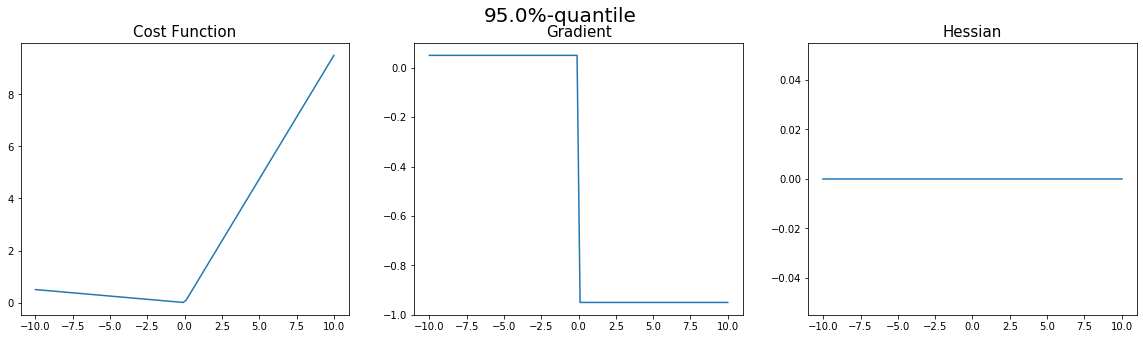

In [2]:
#@title Quantile Cost Function
alpha = 0.95 #@param {type:"number"}
x = np.linspace(-10.,10.,100)
cost = XGBQuantile.quantile_cost(x, alpha)
'''
Plots of gradient, hessian and cost function for quantile regression
'''
fig = plt.figure(figsize=(20,5))

plt.suptitle('{alpha:0.1%}-quantile'.format(alpha=alpha),size=20)
plt.subplot(1, 3, 1)
plt.plot(x, cost)
_ = plt.title('Cost Function', size=15)

grad,hess = XGBQuantile.original_quantile_loss(x, 
                                      np.zeros(len(x)),
                                      alpha=alpha,
                                      delta=0.01)
plt.subplot(1,3,2)
plt.plot(x,grad)
_ = plt.title('Gradient',size=15)

plt.subplot(1,3,3)
plt.plot(x,hess)
_ = plt.title('Hessian',size=15)

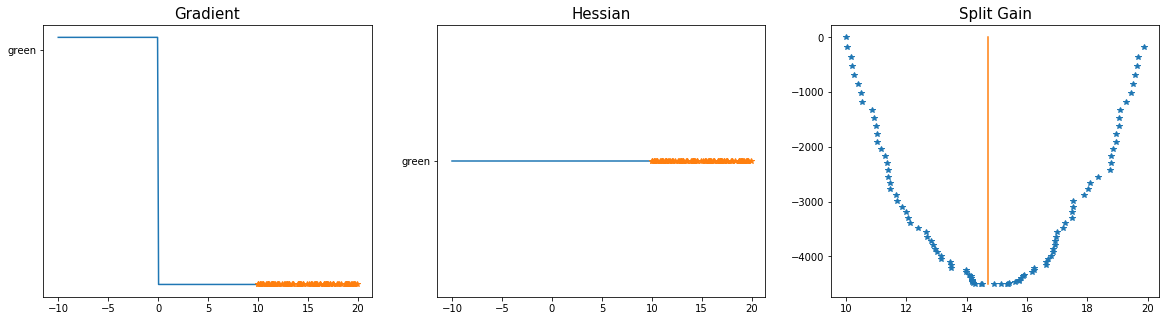

In [3]:
x_min = -10.
x_max = 10.

assert(x_min < x_max),"Please assign x_min < x_max"
alpha = 0.95 #@param {type:"number"}
partition_min =  10#@param {type:"number"}
partition_max = 20 #@param {type:"number"}
data_volume = 100  #@param {type:"number"} #making this half volume to avoid unnecessary issues

VOLUME = data_volume*2
x = np.linspace(x_min,x_max,VOLUME)

x_sample = np.sort((partition_max-partition_min)*np.random.rand(VOLUME//2,)+ partition_min)
grad,hess = XGBQuantile.original_quantile_loss(x, 
                                      np.zeros(len(x)),
                                      alpha=alpha,
                                      delta=0.01)

grad_sample,hess_sample = XGBQuantile.original_quantile_loss(x_sample, 
                                      np.zeros(len(x_sample)),
                                      alpha=alpha,
                                      delta=0.01)
split_gain = XGBQuantile.get_split_gain(grad_sample,hess_sample,l=1.0)

fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,grad)
plt.plot(x_sample,grad_sample,'*','green')
_ = plt.title('Gradient',size=15)

plt.subplot(1,3,2)
plt.plot(x,hess)
_ = plt.title('Hessian',size=15)
plt.plot(x_sample,hess_sample,'*','green')

plt.subplot(1,3,3)
_ = plt.title('Split Gain',size=15)
_ = plt.plot(x_sample,split_gain,'*')
plt.plot(np.ones((VOLUME//2,))*np.median(x_sample),np.linspace(np.min(split_gain),0,VOLUME//2))

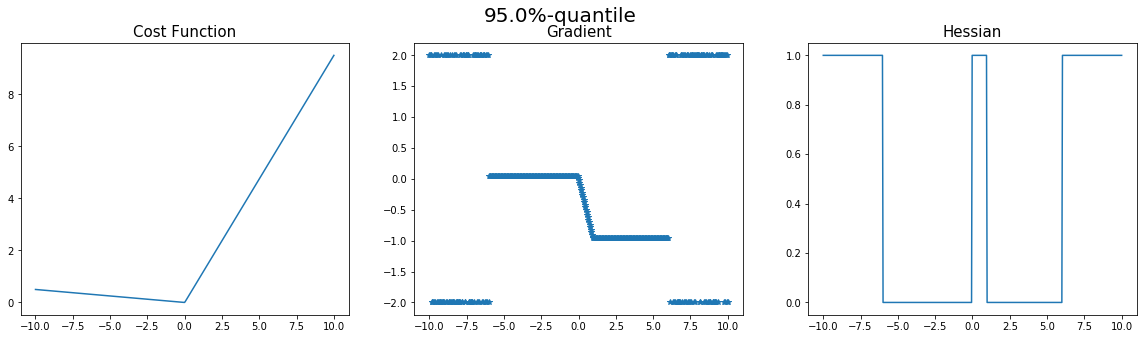

In [4]:
#@title Modified Gradients - Hessian
alpha = 0.95 #@param {type:"number"}
threshold = 6 #@param {type:"number"}
delta = 1.0 #@param {type:"number"}
variance = 2. #@param {type:"number"}
x = np.linspace(-10.,10.,500)

cost = XGBQuantile.quantile_cost(x, alpha)
'''
Plots of gradient, hessian and cost function for quantile regression
'''
fig = plt.figure(figsize=(20,5))

plt.suptitle('{alpha:0.1%}-quantile'.format(alpha=alpha),size=20)
plt.subplot(1,3,1)
plt.plot(x,cost)
_ = plt.title('Cost Function',size=15)

grad,hess = XGBQuantile.quantile_loss(x, 
                                      np.zeros(len(x)),
                                      alpha=alpha,
                                      delta=delta,
                                      threshold=threshold,
                                      var=variance)

plt.subplot(1,3,2)
plt.plot(x,grad,'*')
_ = plt.title('Gradient',size=15)

plt.subplot(1,3,3)
plt.plot(x,hess)
_ = plt.title('Hessian',size=15)

Gradient Boosting alpha = 0.05,score = 185.2
Gradient Boosting alpha = 0.95,score = 190.6
[19:56:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Quantile XGB alpha = 0.05,score = 175.2
Quantile XGB alpha = 0.95,score = 123.1


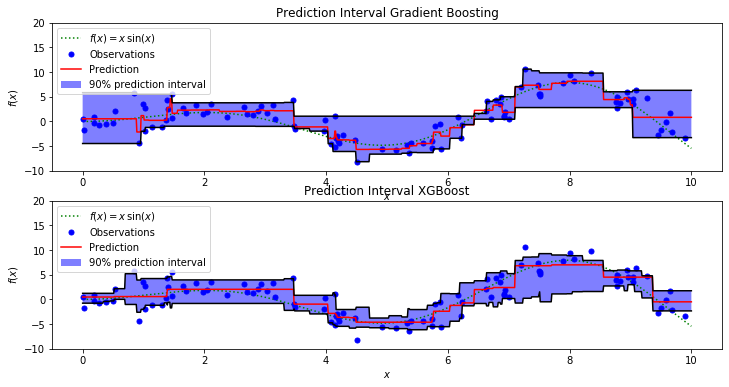

In [8]:
alpha = 0.95 #@param {type:"number"}

X_train, y_train, X_test, y_test = generate_data()


regressor = GradientBoostingRegressor(n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
y_pred = regressor.fit(X_train,y_train).predict(X_test)

regressor.set_params(loss='quantile', alpha=1.-alpha)
y_lower = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=1.-alpha,model_name="Gradient Boosting")
regressor.set_params(loss='quantile', alpha=alpha)
y_upper = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=alpha,model_name="Gradient Boosting")

                                                                 
fig = plt.figure(figsize=(12,6))

plt.subplot(211)
plt.title("Prediction Interval Gradient Boosting")
plot_result(X_train, y_train, X_test, y_test, y_upper, y_lower, y_pred)


regressor = XGBRegressor(n_estimators=250,max_depth=3,reg_alpha=5, reg_lambda=1,gamma=0.5)
y_pred = regressor.fit(X_train,y_train).predict(X_test)

regressor = XGBQuantile(n_estimators=100,max_depth = 3, reg_alpha =5.0,gamma = 0.5,reg_lambda =1.0 )     
regressor.set_params(quant_alpha=1.-alpha,quant_delta=1.0,quant_thres=5.0,quant_var=3.2)

y_lower = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=1.-alpha,model_name="Quantile XGB")
regressor.set_params(quant_alpha=alpha,quant_delta=1.0,quant_thres=6.0,quant_var = 4.2)
y_upper = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=alpha,model_name="Quantile XGB")

plt.subplot(212)
plt.title("Prediction Interval XGBoost")
plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower, y_pred)
